# IR spectral analysis of organic compounds via machine learning approach

### *By: Ray Gunawidjaja*  


-Work in progress (last updated: 010317)-

***********************************************************************************************************************
### A. MOTIVATION  
IR spectroscopy is a versatile and a precise method for chemical identification because every compound exhibits unique IR spectral features; however, the spectral features tend to be ambiguous. A manual interpretation is often time-consuming and may lead to inconsistent, erroneous results. Hence, there is a need for a rapid, accurate, and reproducible alternative to a manual interpretation. 

### B. PURPOSE   
The purpose of this program is to automate the IR spectrum interpretation routine of an unknown compound by assigning it to the reference compound(s) available in the NIST database. The guessed compounds, which is the output are arranged from the most probable to the least probable. The goal of this work is to come up with an accurate and reproducible 'guessing' algorithms.

### C. RATIONALE   
The steps taken by this program are summarized in the form of a flowchart that is shown below:

    1. The steps begin with the NIST chemical list.
    2. With the aid of periodic table of elements, functional group class, and PeakUtils.py package, additional columns 
    are generated (i.e., molecular weight Mw; elements, functional group class, and peaks list).
    3. Using the additional compounds attributes, we can then perform filtering and EDA to reduce the number of entries 
    on the list.
    4. Next, we download the IR spectra of the chemicals shortlist by specifying the CAS number.
    5. Using jcamp, scipy, and numpy packages, read and treat spectra.
    6. Develop models and feed an unknown spectrum into the model to yield the guessed compounds.
 
*NOTES*  
 Re-formatted codes as follows: 
    1. 12/05/17
       -Changed variable and function names to make it more understandable. 
       Now, it uses verbs for function names and noun for variable names.  
       -Added more description in function docstrings. Now, it specified 'args' and 'returns'.
       -Scraped functional group table from a wikipedia website.
       
    2. 12/12/17
       -Files organization: place dependent files into a subfolder called "data" and place downloaded files into a 
       subfolder called "reference".   
       -Autoformatted codes using PEP8 autoformat command in sublimetext.
       -Read jcamp reference spectra, do spectral treatments, and plot data.
       -Added a peak picking function.
       -turned functional group table into a dictionary
       -Added some charts a spart of EDA
       
    3. 12/20/14   
       -Added new columns to the nist_chem_list DataFrame: molecular weight, Mw, and elements.
       -Added new features to classify compounds.
       -Expanded on EDA.
       -To dos: make codes more efficient; validate results; start downloading relevant spectra; start thinking about ML
       approaches.
       
    4. 01/03/17
       -Added common.py file from which functions can be called to perform spectra treatments, baseline subtraction, and 
       to calculate Euclidean distance. 
    
Ref.:  
 http://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html
 
***********************************************************************************************************************

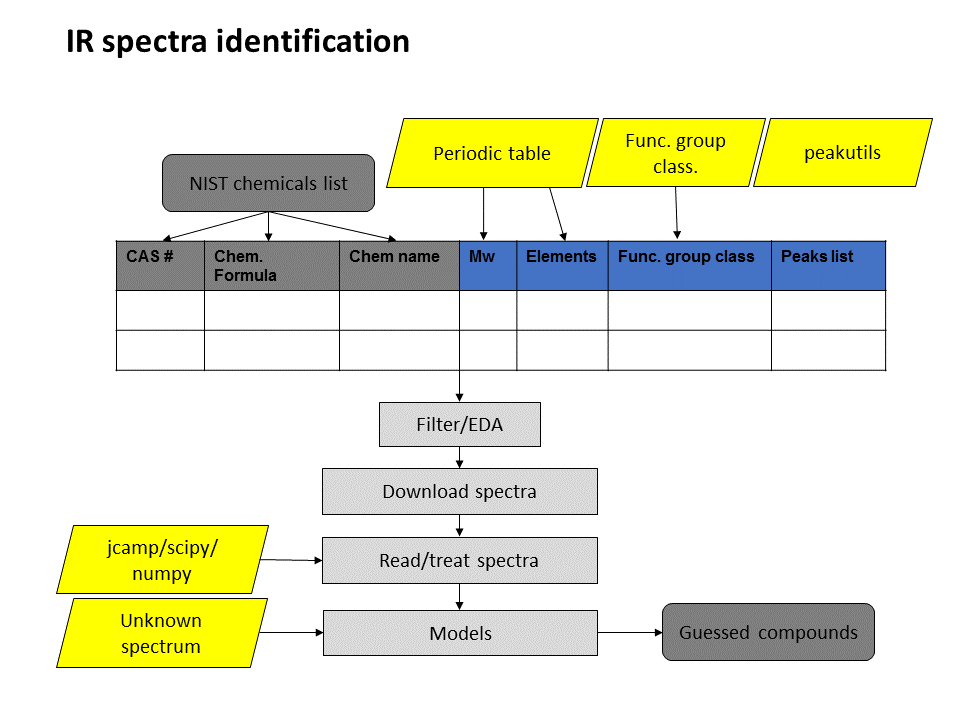

In [4]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo
Image(filename='data/flowchart.png', width=800, height=600)

### OBJECTIVES
    1. Starting with NIST chemicals list, add the columns that correspond to: Mw, elements, functional group 
       class, and peaks.
        
    2. Acquire reference spectra from NIST website and perform spectra treatments.
        
    3. Build machine learning models and test models to enable spectral assignment of an unknown spectrum.

# Obj. 1 Reduce the amount of data sets:  
### Task 1. Funct: Read periodic table of elements and store into a dictionary: 

In [5]:
#create an ordered dictionary. In this case, order of elements is important.
import collections

# periodic_table['element_name']=['atomic_number','atomic_mass']
periodic_table = collections.OrderedDict()  # initialize dictionary.


def create_periodic_table(file_name):
    """ Read a text file line-by-line and extract information for: atomic number, atomic symbol, and relative atomic mass 

        The author is aware of at least one python periodic elements package (e.g., https://pypi.python.org/pypi/periodictable),
        but chose to implement a different approach.
    """

    file = open(file_name, 'r')  # open a file to read

    for line in file:  # read file line-by-line, extract values, and store into a dictionary

        if line.startswith('Atomic Number'):
            line = line.replace(" ", "")
            value1 = line.split('=', 1)

        if line.startswith('Atomic Symbol'):
            line = line.replace(" ", "")
            key = line.split('=', 1)

        if line.startswith('Relative Atomic Mass'):
            line = line.replace(" ", "")
            value2 = line.split('=', 1)

            # Store values into dictionary only if the element is unique.
            # Otherwise, the atomic mass will be override by isotope's atomic
            # mass.
            if key[1].strip() not in list(periodic_table.keys()):
                periodic_table[key[1].strip()] = [
                    value1[1].strip(), value2[1].strip()]
            else:
                pass

    return periodic_table

# End of functions

In [6]:
# 1-1a. Call out function
file_name = 'data/NIST_periodic_table.txt'
periodic_table = create_periodic_table(file_name)

# 1-1b.Test out dictionary by calling out the element keys
print(list(periodic_table.keys()))
print("\n")
print("Number of dictinct elements in the dictionary:", len(periodic_table))

['H', 'D', 'T', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


Number of dictinct elements in the dictionary: 120


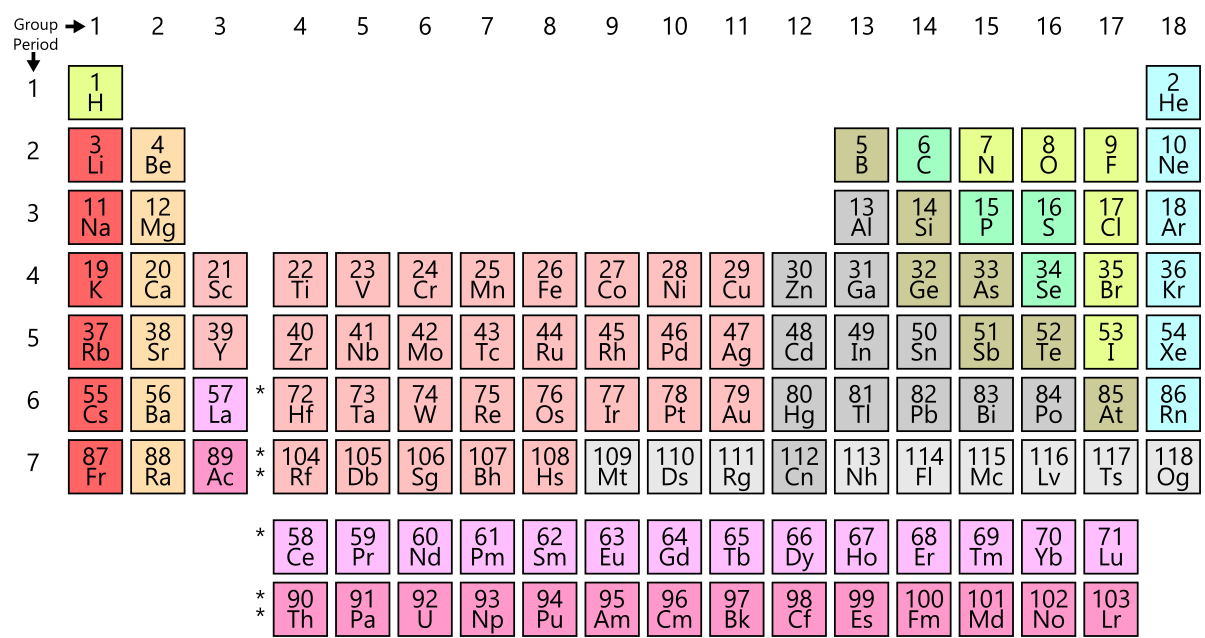

In [7]:
Image(filename='data/Periodic_Table_wiki.png', width=800, height=600)

### [✓] Obj.1 Task 1 is completed. 

The above shows the dictionary keys showing the 120 periodic table elements with (i.e., 118 being the distinct elements and 2 being the hydrogen isotopes, D and T). 

### Obj. 1 Task2: Create tools to analyze NIST chemicals list containing 40K+ enteries. 

In [8]:
import pandas as pd
import re  # for string manipulations
import requests
from bs4 import BeautifulSoup  # for webscraping
from peakutils.peak import indexes as index_utils  # for peak picking


def read_and_clean_nist_chem_list(no_of_files=72619):
    """ Read and clean a stored csv file called "NIST_chemicals_list.csv" 

    Args:
    no_of_files=specifies how many files to read from the list. The max. no. is 72619.

    Returns:
    a NIST chemicals list dataframe.

    """

    # read file
    col_names = ['Name', 'Formula', 'CAS']
    # Rename columns
    df = pd.read_csv("data/NIST_chemicals_list.csv", header=1, names=col_names)
    # Remove rows that have null objects and keep only rows with no na values
    df = df.dropna()
    # make CAS the index column
    df = df.set_index('CAS')

    return df

"""
def extract_unique_elements(df, periodic_table_list):
    ##Extract unique elements and add to the list: unique_elements 

    Args:
    df=specify a dataframe from which we want to extract the unique elements
    periodic_table_list=specify the periodic table dataframe to be used to extract the known elements of the
    periodic table

    Returns:
    unique_elements=return only the unique elements that make up all compounds in the dataframe

    ##

    # An array for storing element_list and unique_elements in NIST chemicals
    # list
    elements_list = []
    unique_elements = []

    # create a list of elements from periodic table: elements_list
    for element in periodic_table_list:
        elements_list.append(element)

    # determine distinct elements: check which element is present in formula.
    # If not yet in unique_elements list, add it
    for each in df.Formula:
        for element in elements_list:
            if (element in each) and (element not in unique_elements):
                unique_elements.append(element)

    return unique_elements
"""
    
def extract_unique_elements(df):
    """Given a pandas DataFrame containing a column of chemical formula, return the DataFrame 
        with an additional column containing unique elements in the formula called df['Elements']
    
        Args:
        df_Formula=a column of chemical formula in a pandas DataFrame
        Return:
        a list of unique elements
    """

    #1a. check for formulas that contain ')n' and remove it
    ##df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','')   
    df.loc[df['Formula'].str.contains('\)n')==True,'Formula']=df[df['Formula'].str.contains('\)n')==True]['Formula'].str.replace('\)n','') 
    #1b. check for formulas that contain '.xW' and remove it
    df.loc[df['Formula'].str.contains('xW')==True,'Formula']=df[df['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1c. check for formulas that contain '.XH2O' and remove it
    df.loc[df['Formula'].str.contains('XH2O')==True,'Formula']=df[df['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1d. check for formulas that contain 'xC6' and remove it
    df.loc[df['Formula'].str.contains('xC6')==True,'Formula']=df[df['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    #2. apply regex to extract unique elements in chemical formula
    df['Elements'] = df['Formula'].str.replace('[^a-z,A-Z]+', '') #Extract only alphabets and drop numbers
    #3. df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    df['Elements'] = df['Elements'].str.findall('[A-Z][^A-Z]*') 
    return df


def filter_by_elements(df, elements_list):
    """ Filter compounds to contain any, but not exceeding the elements on the specified list: elements_list s

    Args:
    df=specify a dataframe on which we want to perform filtering by elements.
    elements_list=provide a list of elements in which the desired compounds contain, e.g., ['C', 'O', 'H']

    Returns:
    returns compounds that contain the listed elements.

    """

    # Create a blank pandas DataFrame
    new_df = pd.DataFrame()

    for i, element in enumerate(df.Formula):
        # strip chemical formula and leave out only the alphabets
        s_proc = re.sub('[^a-zA-Z]+', '', element)
        for allowed_element in elements_list:
            # subtract stripped formula with elements list
            s_proc = s_proc.replace(allowed_element, "")
            #print("s_proc:", s_proc)
            # If the stripped formula is completely anihilated, then all elements must have matched
            # Thus, append compound to the new DataFrame
            if (s_proc == ""):
                #    print("s_proc:", s_proc)
                new_df = new_df.append(df.iloc[i, :])
            # s_proc=re.findall('\D+', each) #extract only letters

    # relabel index column
    new_df.index.name = "CAS"
    return new_df  # returns a list


def calc_molec_weight(nist_chem_list, periodic_table):
    """ Calculate molecular weight, Mw, given a chemical formula, df.Formula 
    #ref.: https://stackoverflow.com/questions/41818916/calculate-molecular-weight-based-on-chemical-formula-using-python

    Args:
    nist_chem_list=a pandas DataFrame from which Mw will be calculated.
    periodic_table=a periodic table dictionary from which the atomic weight of each element can be retrieved.

    Returns:
    the same dataframe, but with an extra column added. This extra column is labelled as 'Mw'.

    """

    #1a. check for formulas that contain '.xW' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xW'),'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xW')==True]['Formula'].str.replace('x','')
    #1b. check for formulas that contain '.XH2O' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('XH2O')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('XH2O')==True]['Formula'].str.replace('X','')
    #1c. check for formulas that contain 'xC6' and remove it
    nist_chem_list.loc[nist_chem_list['Formula'].str.contains('xC6')==True,'Formula']=nist_chem_list[nist_chem_list['Formula'].str.contains('xC6')==True]['Formula'].str.replace('x','')

    
    for i, each in enumerate(nist_chem_list.Formula):

        # separate atomic symbols from atomic ratios
        total_weight = 0  # initialize total weight
        s = re.findall('([A-Z][a-z]?)([0-9]*)', each)

        for elem, count in s:
            if count == '':  # For singular elements
                count = 1
            else:
                pass
            try:
                total_weight += int(count) * \
                    float(re.sub('[(#)]', '', periodic_table[elem][1]))
            except: 
                print("error:", nist_chem_list.iloc[i,1])
                continue

        # Append total weight to a new column in pandas DataFrame
        nist_chem_list.loc[nist_chem_list.index[i], 'Mw'] = total_weight
    return nist_chem_list
    

def create_func_group_table():
    """ Scrape a table from wikipedia and load it into a pandas DataFrame 

    Args:
    None

    Returns:
    df=a pandas DataFrame of functional group classification.

    """

    # Request information from wikipedia
    res = requests.get(
        "https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups")

    # Create a BeautifulSoup class
    soup = BeautifulSoup(res.content, 'lxml')

    # Extract info. from a table
    table = soup.find_all(class_="wikitable")[0]

    # Load table info. into a Pandas DataFrame
    df = pd.read_html(str(table), header=0)[0] #, index_col='Chemical class')[0]
    
    return df


def pick_peaks(title_name, x, y):
    """ Given x and y values, pick peaks using PeakUtils python package by identifying peak maxima and plot graphs. 
        This algorithm is a 1-D search. In the calculation, it doesn't account for the x-values.

        ref.: https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work

    parameters:
    The sensitivity of the peak picking algorithm can be varied by changing the thres and min-dist 
    in the index_utils object (see below).

    Args:
    title_name=specify the title of the data, which will be displayed on the final plot. 
    x=specfy x values.
    y=specfy y values.

    Returns:
    plots spectra with marked peaks.

    """

    # print('Detect peaks with minimum height and distance filters.')
    index_utils = index_utils(np.array(y), thres=0.02 / max(y), min_dist=5)
    # print('Peaks are: %s' % (indexes))

    x_max = []
    y_max = []

    for each in index_utils:
        x_max.append(x[each])
        y_max.append(y[each])

    # plot the x,y pair of the identified maxima data points, i.e., indexes,
    # max_peaks:
    plt.plot(x, y)
    plt.plot(x_max, y_max, 'rD', alpha=0.3)

    plt.title(title_name)
    plt.ylabel("Absorbance")  # All units are transformed to absorbance
    plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm

# End of functions

In [9]:
import matplotlib.pyplot as plt

# 1-2a. Generate nist chemicals list by calling out the read_and_clean_nist_chem_list function 
nist_chem_list = read_and_clean_nist_chem_list()
# print(df.head()) #check

# 1-2b. Calculate molecular weight of compounds and append to
# nist_chem_list: nist_chem_list_app1
##nist_chem_list_app1 = calc_molec_weight(filtered_nist_chem_list, periodic_table)
nist_chem_list_Mw = calc_molec_weight(nist_chem_list, periodic_table)
#print(nist_chem_list_Mw.head(5)) #check

#1-2c
#Extract unique elements and append a new column called 'Elements'
nist_chem_list_Mw_el=extract_unique_elements(nist_chem_list_Mw)
print(nist_chem_list_Mw_el.head(5)) #check


                                                        Name     Formula  \
CAS                                                                        
100-00-5                          Benzene, 1-chloro-4-nitro-   C6H4ClNO2   
100-01-6                                      p-Nitroaniline    C6H6N2O2   
100-02-7                                    Phenol, 4-nitro-     C6H5NO3   
100043-29-6                                     2H-Tetrazole       CH2N4   
100046-00-2  2,2,4,4',6,6'-Hexamethylazobenzene N,N'-dioxide  C18H22N2O2   

                     Mw          Elements  
CAS                                        
100-00-5     156.993056  [C, H, Cl, N, O]  
100-01-6     138.042927      [C, H, N, O]  
100-02-7     139.026943      [C, H, N, O]  
100043-29-6   70.027946         [C, H, N]  
100046-00-2  298.168128      [C, H, N, O]  


In [10]:
#WORK IN PROGRESS

# 1-2d. Create a functional group table DataFrame
func_group_table = create_func_group_table()
#print(func_group_table.head())

#strip off '-'
func_group_table.loc[func_group_table['Suffix'].str.contains('-')==True,'Suffix']=func_group_table[func_group_table['Suffix'].str.contains('-')==True]['Suffix'].str.replace('-','')
func_group_table.loc[func_group_table['Prefix'].str.contains('-')==True,'Prefix']=func_group_table[func_group_table['Prefix'].str.contains('-')==True]['Prefix'].str.replace('-','')
##print(func_group_table)

#Create a new column with functional group assignment
#WORK IN PROGRESS

"""
for i,j in enumerate(nist_chem_list_Mw_el.Name):
    #print(nist_chem_list_Mw_el.Name.str.contains(j))
    print(nist_chem_list_Mw_el.Name.str.contains(j))
        #print("Yes")
        #print(nist_chem_list_Mw_el.Name.iloc[i])
"""


'\nfor i,j in enumerate(nist_chem_list_Mw_el.Name):\n    #print(nist_chem_list_Mw_el.Name.str.contains(j))\n    print(nist_chem_list_Mw_el.Name.str.contains(j))\n        #print("Yes")\n        #print(nist_chem_list_Mw_el.Name.iloc[i])\n'

### Cluster chemicals list into known groups

In [11]:
#Check for chemicals that contains certain elements
#I. Generate elements list

#A. organic compounds
organic=['C','H','O','N','S','P','B','Cl', 'F', 'I', 'Br'] 

#B. Transition metals
t_metals=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(22,32):
        t_metals.append(j)
    elif i in range(40,50):
        t_metals.append(j)
    elif i in range(73,82):
        t_metals.append(j)

print(t_metals)

#C. lanthanides and actinides list is no 57-71 and 89-103
f_block=[]

for i,j in enumerate(periodic_table.keys()):
    if i in range(58,73):
        f_block.append(j)
    elif i in range(90,105):
        f_block.append(j)
print('\n')
print(f_block)

##############################
#II. group elements based on the elements list

#A. organic compounds
nist_chem_list_organic=[]

#Return chemicals with at least one matching elements in the list
[nist_chem_list_organic.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(organic))==0] #Check for matching elements

nist_chem_list_organic=pd.DataFrame(nist_chem_list_organic) #convert list into a dataframe

#print(pd.DataFrame(nist_chem_list_organic))

##nist_chem_list_organic.info()

print("No. of organic compounds:", len(nist_chem_list_organic.Name))

#print(nist_chem_list[set(nist_chem_list.Elements).intersection(list1)])

#[print(nist_chem_list.Elements) if e in nist_chem_list.Elements]
#set(nist_chem_list.Elements).intersection(list1)
#nist_chem_list.columns

#B. Transition metals
nist_chem_list_t_metals=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_t_metals.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(t_metals))==0] #Check for matching elements

nist_chem_list_t_metals=pd.DataFrame(nist_chem_list_t_metals) #convert list to pandas dataframe

print("No. of transition metals:", len(nist_chem_list_t_metals))

##nist_chem_list_t_metals.info()
#print(nist_chem_list_t_metals)

#C. lanthanides

nist_chem_list_f_block=[]

#filter for transition metals
#Return chemicals with at least one matching elements in the list
[nist_chem_list_f_block.append(nist_chem_list.iloc[i,:]) for i,e in enumerate(nist_chem_list.iloc[:,3]) if bool(set(e).difference(f_block))==0] #Check for matching elements

nist_chem_list_f_block=pd.DataFrame(nist_chem_list_f_block) #convert list to pandas dataframe

print("No. of f-blocks:", len(nist_chem_list_f_block))
#print('\n')
##nist_chem_list_lanthanides.info()
#print(nist_chem_list_lanthanides)

import matplotlib.pyplot as plt



['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg']


['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
No. of organic compounds: 37611
No. of transition metals: 361
No. of f-blocks: 40


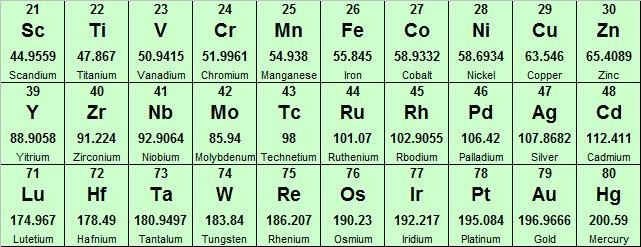

In [12]:
Image(filename='data/t_metals.jpg', width=600, height=400)

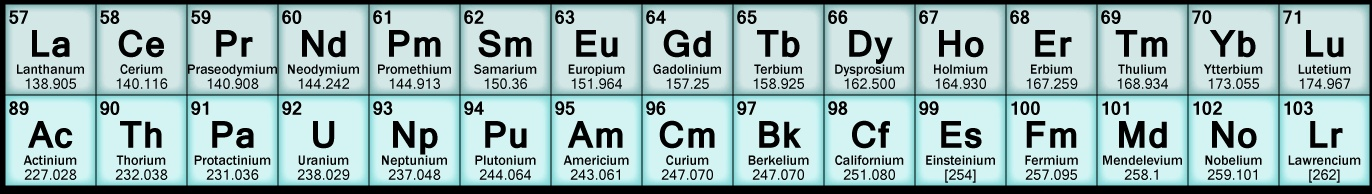

In [13]:
Image(filename='data/lanthanides.jpg', width=600, height=400)

### [✓] Obj. 1 Task 2 is partially completed. 

The following tools have been implemented: 
    
    -For determining the unique elements present in the NIST chemicals list. 
    -For filtering compounds that contain specific set of elements
    -For calculating molecular weight of compounds
    
    *Two more features that need to be implemented are:
        a. Classifying the compounds into various families of function groups: 
        ref.: https://en.wikibooks.org/wiki/Organic_Chemistry/Overview_of_Functional_Groups
        -> The function for web scraping has been created. The next step is to implement this function on the compounds.
        b. Identify peaks in each of the spectra and add a new column that lists the picked peaks.

### Obj. 1 Task 3: Perform EDA to classify and shorten the NIST chemicals list  

I. Fraction of various chemical groups

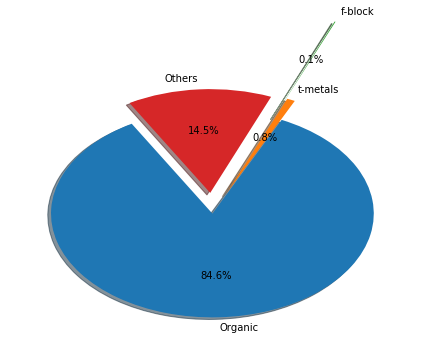

Compounds breakdown:


 Organic: 37611

 t-metals: 361

 f-block: 40

 Others: 6443

 Total: 44455


In [14]:
#draw pie chart
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Organic', 't-metals', 'f-block', 'Others' 
others=len(nist_chem_list)-sum([len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block)])
sizes = [len(nist_chem_list_organic),len(nist_chem_list_t_metals),len(nist_chem_list_f_block), others]
explode = (0, 0.2, 1.0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, shadow=True, startangle=120, autopct='%1.1f%%')
#fig1, ax1 = plt.subplots()
#ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#        shadow=True, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

print("Compounds breakdown:\n")
print("\n Organic:", len(nist_chem_list_organic))
print("\n t-metals:", len(nist_chem_list_t_metals))
print("\n f-block:", len(nist_chem_list_f_block))
print("\n Others:", others)
print("\n Total:", len(nist_chem_list))


II. Molecular weight distributions

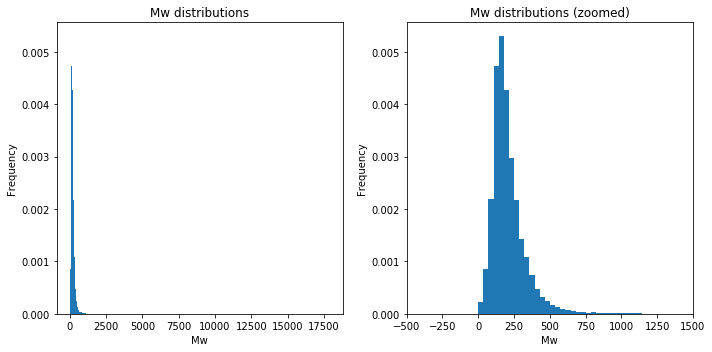

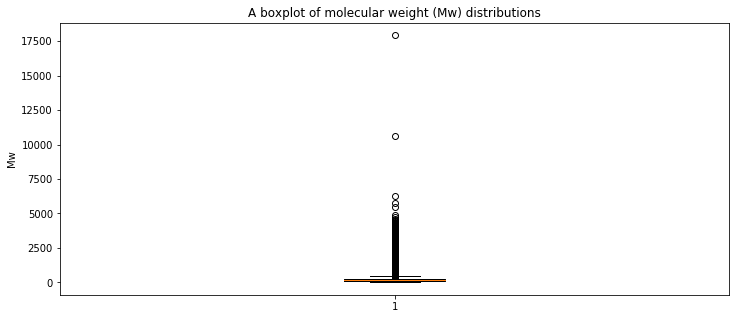



Some statistics count    44455.000000
mean       221.754239
std        231.506335
min          0.000000
25%        136.125201
50%        184.052429
75%        256.096026
max      17912.691751
Name: Mw, dtype: float64


<class 'pandas.core.frame.DataFrame'>
Index: 44455 entries, 100-00-5 to 999-97-3
Data columns (total 4 columns):
Name        44455 non-null object
Formula     44455 non-null object
Mw          44455 non-null float64
Elements    44455 non-null object
dtypes: float64(1), object(3)
memory usage: 2.9+ MB
Data overview None


In [15]:
# A. Generate a histogram of molecular weight distribution
# plt.figure(figsize=(20,10))

##nist_chem_list_app1.Mw.plot(kind='hist', bins=100, normed=True)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500, normed=True)
plt.xlabel('Mw')
plt.title('Mw distributions')

plt.subplot(1,2,2)
nist_chem_list_Mw_el.Mw.plot(kind='hist', bins=500, normed=True)
plt.xlabel('Mw')
plt.xlim(-500,1500)
plt.title('Mw distributions (zoomed)')
plt.tight_layout()

# B. show a box plot of Mw distributions
plt.figure(figsize=(12,5))

# nist_chem_list_app1.Mw.plot(kind='box')
plt.boxplot(nist_chem_list_Mw_el.Mw)

plt.title('A boxplot of molecular weight (Mw) distributions')
plt.ylabel('Mw')

plt.show()

print("\n")
print("Some statistics", nist_chem_list_Mw_el.Mw.describe())
print("\n")
print("Data overview", nist_chem_list_Mw_el.info())


In [16]:
#check which compounds are in the outliers
#A. Mw=0
mw_eq_0=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw==0]
print("No of elements with Mw=0:", len(mw_eq_0))

#check original entries
##cas_list=['25988-63-0', '26700-39-0', '26982-20-7', '61257-62-3', '61857-39-4']
#nist_chem_list.index.name

#print(nist_chem_list.head())   
##df=pd.read_csv("data/NIST_chemicals_list.csv")    
##df.columns=['Name','Formula','CAS']
##df.head(3)

#nist_chem_list.loc['26700-39-0']
##for i in cas_list:
##    print(df[df['CAS']==i])

#B. Mw>1000
mw_gt_1000=nist_chem_list_Mw_el[nist_chem_list_Mw_el.Mw>1000]
print("No of elements with Mw>1000:",len(mw_gt_1000))
#print(mw_gt_1000)
#print(mw_gt_1000.index)
#print(len(mw_gt_1000))    

#C. Check for duplicates
print("Number of chemicals in the list:", len(nist_chem_list_Mw_el.iloc[:,0]))
print("Number of chemicals with unique CAS number in the list:", len(set(nist_chem_list_Mw_el.index))) 
#There are no duplicates. Good!



No of elements with Mw=0: 5
No of elements with Mw>1000: 271
Number of chemicals in the list: 44455
Number of chemicals with unique CAS number in the list: 44455


_________________________________________________________________________________________________________


# Obj. 2  Acquire reference spectra (in jcamp format) using the shortlist and analyze spectra

In [42]:
import urllib.request
import requests


def download_jcamp_from_nist(df, minimum_file_size=1000, no_of_files=20):
    """ Download jcamp files from NIST website by calling out CAS values (i.e., the df index) from chemicals DataFrame, df 

    Args:
    df=a pandas DataFrame consisting a CAS no, column as the index.
    size=the minimum file size at which the file will be downloaded.
    no_of_files=the number of files to download.

    Returns:
    automatically saves files into the same directory as this python program.
    print the name of the downloaded files.

    """

    # NOTE THAT SOME OF THESE FILES TURN out to be empty.
    # Need to check file size before proceeding. Don't download if empty.
    # Files are saved in the same folder as this python script.

    # Download data based on CAS number partially
    for cas_no in df.index[:no_of_files]:
        # specify CAS no. separately
        url = "http://webbook.nist.gov/cgi/cbook.cgi?JCAMP=C%s&Index=0&Type=IR" % (
            cas_no)

        try:

            # Download only if size is significant. 1000 seems optimum.
            if len(requests.get(url).content) >= 1000:
                # Strip comma, apostrophe, and space in the file name because
                # it will mess up the ability of the jcamp program to read the
                # file.
                url_ret = urllib.request.urlretrieve(url, "reference/%s" %(df.loc[cas_no, 'Name'].replace(",", "").replace("'", "").strip() + "_" + cas_no))  # save file according to its cas_no
                print(url_ret)  # print list of downloaded compounds
        except:
            continue
# End of functions

# Need to complicate the approach by filtering the types of compounds

### Obj2. Task 1: Download spectra using shortened NIST chemical list

In [43]:
# Call out function to download. Place downloaded files into the "reference" folder.
download_jcamp_from_nist(nist_chem_list_organic, 1000, 10)
# print(nist_chem_list_organic)

('reference/Benzene 1-chloro-4-nitro-_100-00-5', <http.client.HTTPMessage object at 0x000000000ED6AC50>)
('reference/p-Nitroaniline_100-01-6', <http.client.HTTPMessage object at 0x000000000ED6AF98>)
('reference/Phenol 4-nitro-_100-02-7', <http.client.HTTPMessage object at 0x000000000ED6A860>)
('reference/Cyclohexanol 2-(9h-purin-9-yl)- trans-_100057-61-2', <http.client.HTTPMessage object at 0x000000000ED6AFD0>)
('reference/9H-purine 9-cyclohex-2-enyl-6-hydrazino-_100058-19-3', <http.client.HTTPMessage object at 0x000000000ED6A4E0>)
('reference/Acetophenone 4-methoxy-_100-06-1', <http.client.HTTPMessage object at 0x000000000ED6A080>)


### Obj2. Task 2: Uniformize units and plot spectra.

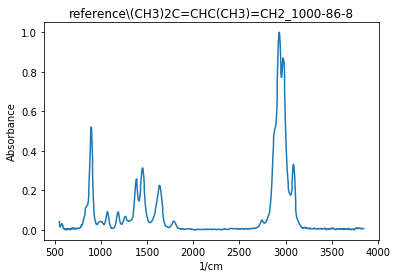

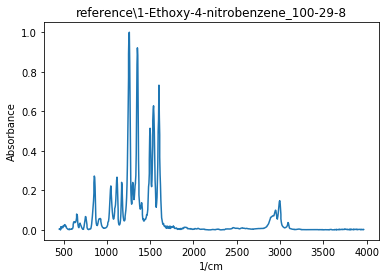

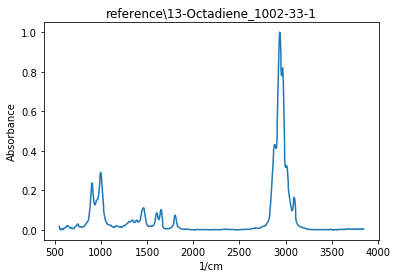

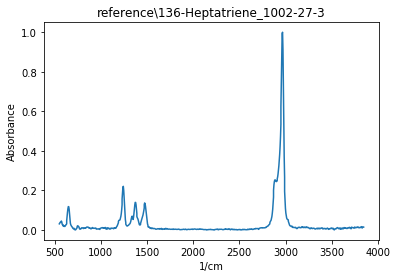

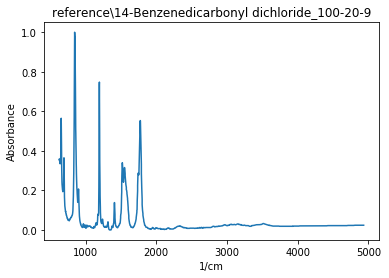

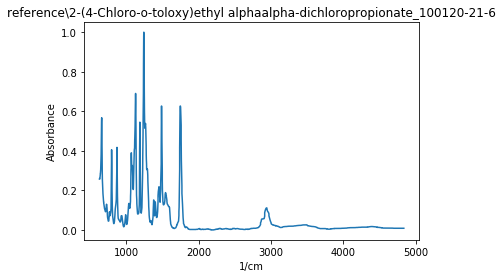

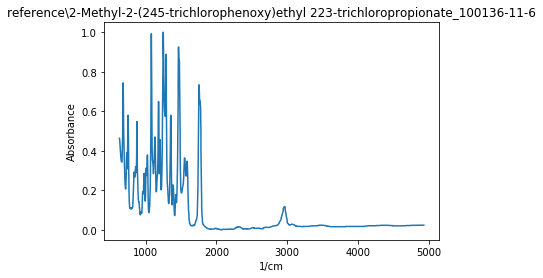

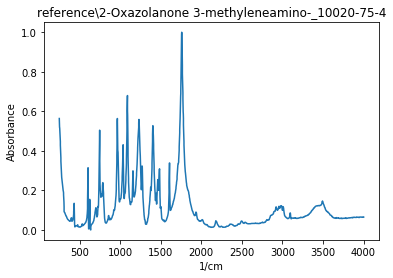

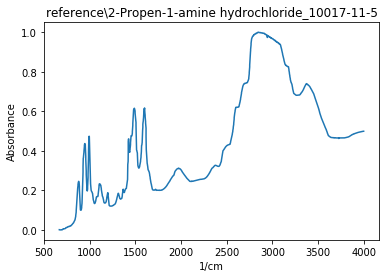

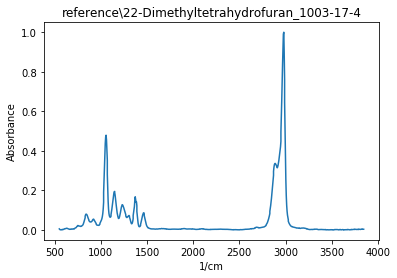

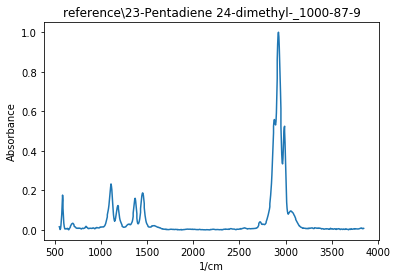

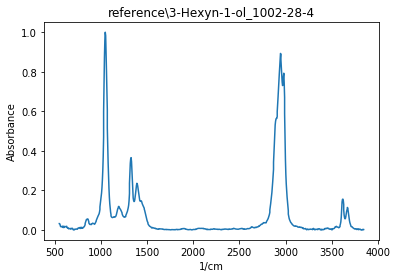

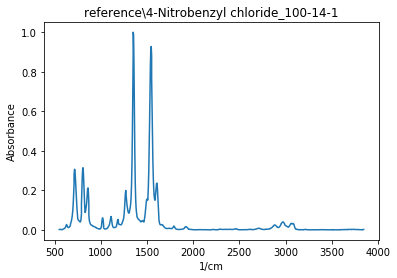

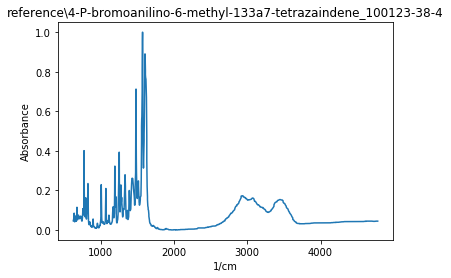

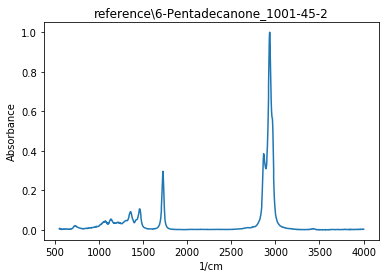

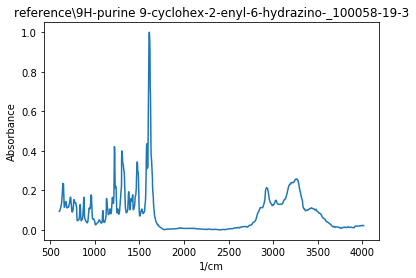

C:\Users\rayg\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10
C:\Users\rayg\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rayg\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


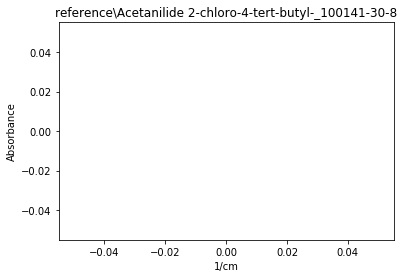

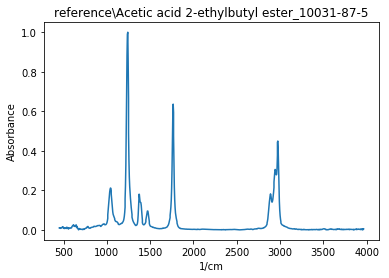

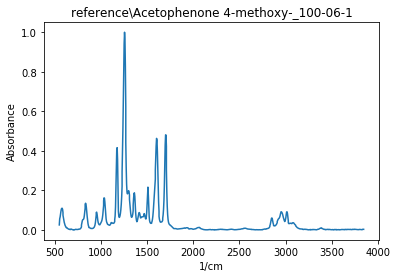

In [19]:
# Plot all spectra that are located in the "reference" folder
# Use jcamp codes to read jcamp files using jcamp package (taken from:
# https://pypi.python.org/pypi/jcamp/1.2.1).

import my_jcamp as jcamp
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Create an empty list to store spectra data
ref_spectra = []


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('reference/*')  # look for files without extension. Returns a list.


# Try to read the file. If can't be read, skip it.
for i, file in enumerate(files):
    # files="2-(4-Chloro-o-toloxy)ethyl alphaalpha-dichloropropionate_100120-21-6"
    # print(file)
    try:
        # read jcamp file using the jcamp class and store data into the
        # ref_spectra list
        ref_spectra.append(jcamp.JCAMP_reader(file))

        # uniformize data, #1:
        # check yunits: If yunits is in transmission, change it to absorbance.
        # Later create a function to uniformize units
        if ref_spectra[i]['yunits'] == "ABSORBANCE":
            pass 

        elif ref_spectra[i]['yunits'] == "TRANSMISSION" or "TRANSMITTANCE":
            ref_spectra[i]['y'] = 2 - np.log10(ref_spectra[i]['y'])
            #normalize
            ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # check xunits: if in microns, change to 1/cm
        if ref_spectra[i]['xunits'] == "MICROMETERS":
            ref_spectra[i]['x'] = 10000 / ref_spectra[i]['x']

        # uniformize data, #2:
        # normalize absorbance peaks (y-values) to between 0 and 1.
        ref_spectra[i]['y'] = (ref_spectra[i]['y']-min(ref_spectra[i]['y'])) / max(ref_spectra[i]['y'])

        # !Still need to uniformize x-axis range and uniformize x-axis intervals.
       
        # plot data to allow visual inspections
        plt.plot(ref_spectra[i]['x'], ref_spectra[i]['y'])
        plt.title(file)
        plt.xlabel('1/cm')
        plt.ylabel('Absorbance')
        plt.show()

    except:
        # print("File can't be read, please check:", files)
         continue

In [20]:
# peak picking function

#I need to do a baseline subtraction and, perhaps, smoothing, using polyfit, so that the peak picking is the same throughout.

def pick_peaks(compound_name, x, y):
    from peakutils.peak import indexes as index_utils

    """ Identify peaks maxima. This algorithm is a 1-D search. It doesn't account for the x-values.
        ref.: #https://stackoverflow.com/questions/31016267/peak-detection-in-python-how-does-the-scipy-signal-find-peaks-cwt-function-work
        
        Args:
        compound_name=to be used asa title in the generated plot (string).
        x=x-values (list)
        y=y-values (list)
        Returns:
        uses peakutils package to pick peaks in 1-D and plot out the x,y values, along with the identified peak maxima.
    """

    index_utils = index_utils(np.array(y), thres=0.025 / max(y), min_dist=5)
    # print('Peaks are: %s' % (indexes))

    x_max = []
    y_max = []

    for each in index_utils:
        x_max.append(x[each])
        y_max.append(y[each])

    # plot the x,y pair of the identified maxima data points, i.e., indexes,
    # max_peaks:
    plt.plot(x, y, 'b-')
    plt.plot(x_max, y_max, 'rD', alpha=0.3)

    plt.title(compound_name)
    plt.ylabel("Absorbance")  # All units are transformed to absorbance
    plt.xlabel("Wavenumber, cm-1")  # all units are transformed into 1/cm
    plt.show()

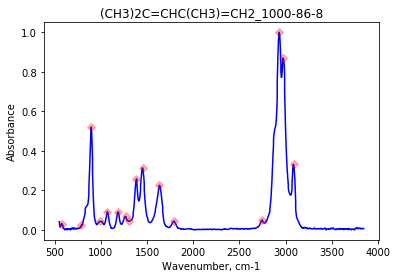

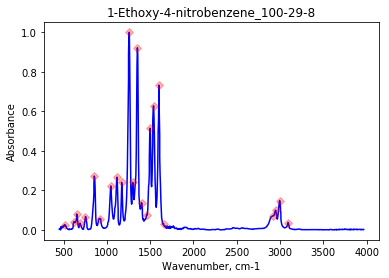

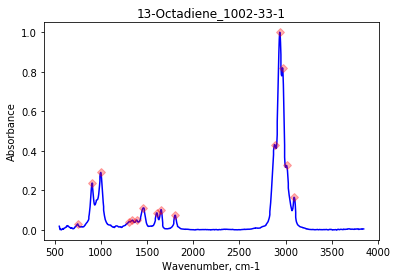

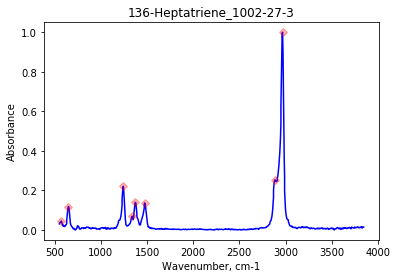

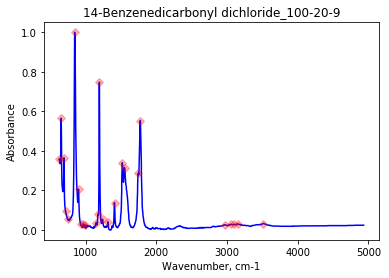

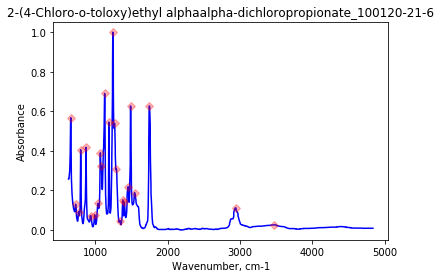

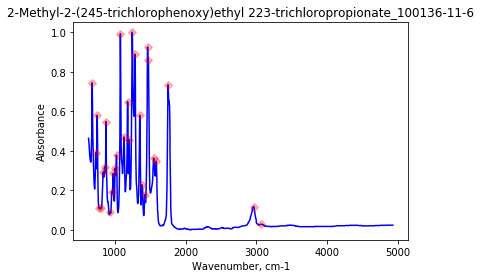

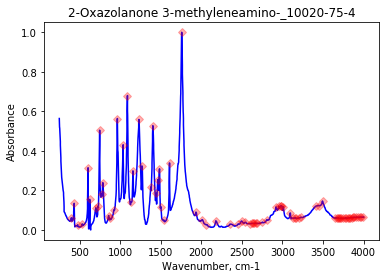

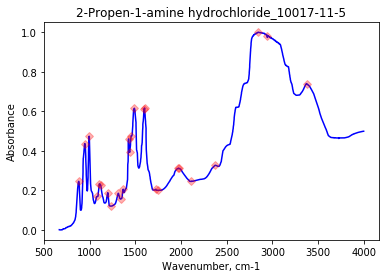

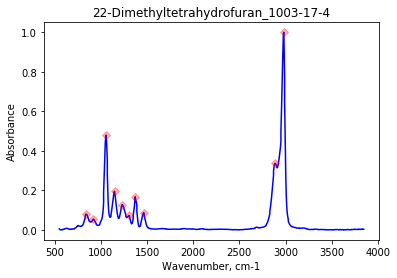

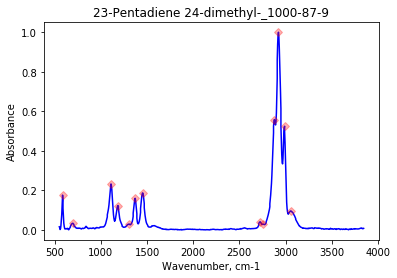

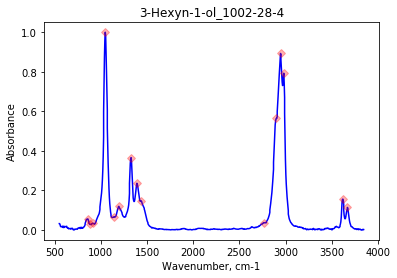

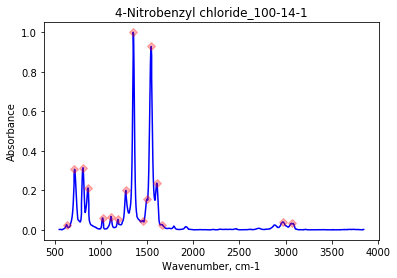

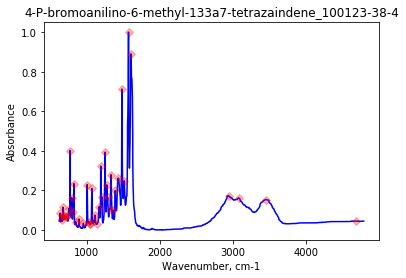

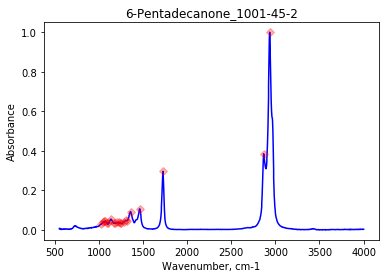

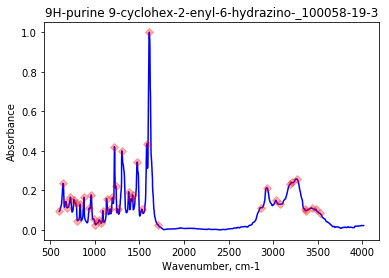

C:\Users\rayg\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\peakutils\peak.py:62: RuntimeWarning: invalid value encountered in less
  & (y > thres))[0]
C:\Users\rayg\AppData\Local\Continuum\Anaconda2\envs\py36\lib\site-packages\peakutils\peak.py:62: RuntimeWarning: invalid value encountered in greater
  & (y > thres))[0]


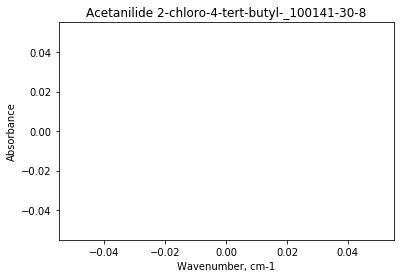

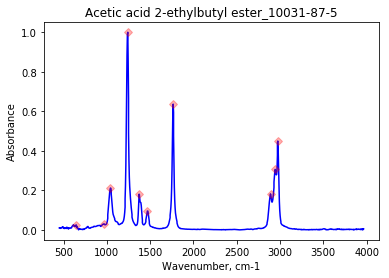

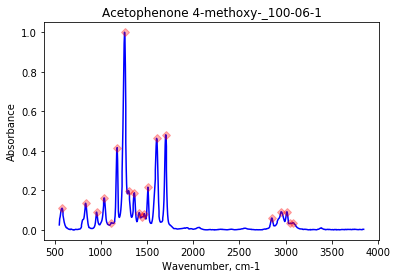

In [21]:
# call pick_peaks function

for spectrum in ref_spectra:
    pick_peaks(spectrum['filename'].split('\\')[1], spectrum['x'], spectrum['y'])

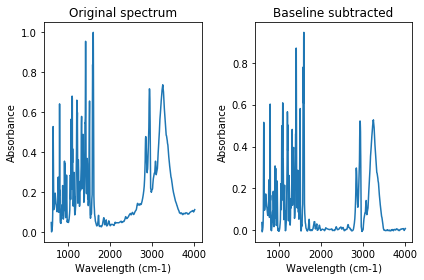

In [36]:
from common import *
#apply airPLS to your spectrum to do baseline subtraction. Functions are store in common.py. 

#import data: 
file="reference/Cyclohexanol 2-(9h-purin-9-yl)- trans-_100057-61-2"
df=jcamp.JCAMP_reader(file)
df.keys() #check

#apply function
treated_df=standardize_units_and_normalize_peaks(df)
orig_y=treated_df['y']
orig_x=treated_df['x']

treated_y=orig_y-airPLS(orig_y)

plt.plot(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(orig_x,orig_y)

plt.title('Original spectrum')
plt.ylabel('Absorbance')
plt.xlabel('Wavelength (cm-1)')

plt.subplot(1,2,2)
plt.plot(orig_x,treated_y)

plt.title('Baseline subtracted')
plt.ylabel('Absorbance')
plt.xlabel('Wavelength (cm-1)')
plt.tight_layout()
plt.show()

_________________________________________________________________________________________________________


# Obj. 3 Modeling and testing

The spectral assignment will be done according to two main approaches:
    1. -Picking out the unique feature in the spectrum (e.g., pick high intensity peaks).
       -Extracting reference spectra in the database that contain the same unique features.
    
    2. Subtracting the unknown spectrum from each of the reference spectrum 
       and rank the reference spectra from the most to the least alike. 
       The likeness of the spectra can be measured from e.g., residuals.
 
#In progress 

I. Spectral matching using a conventional method: Euclidean distance

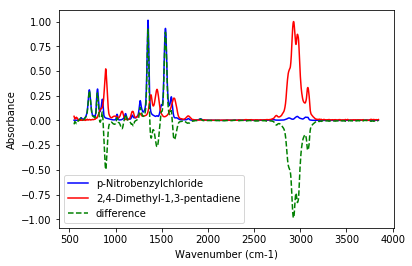

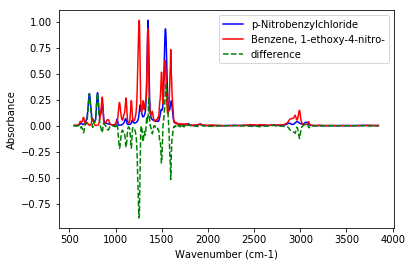

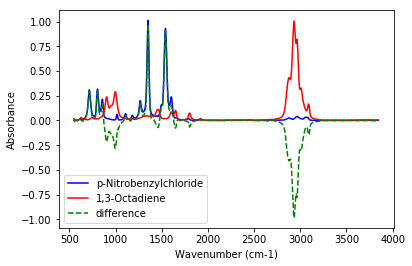

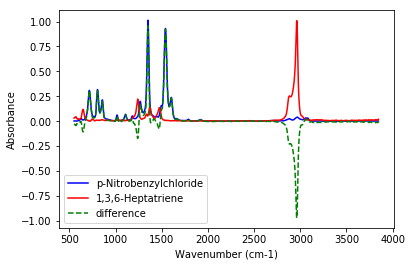

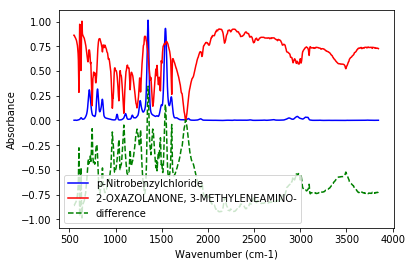

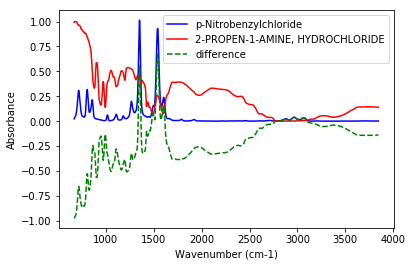

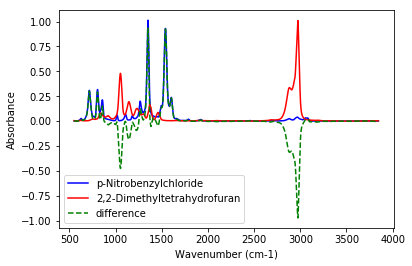

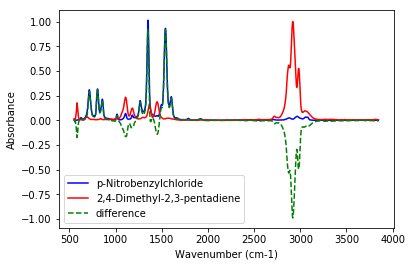

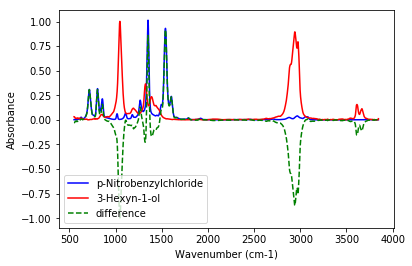

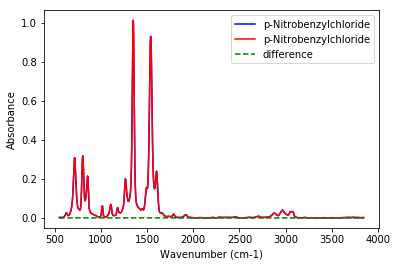

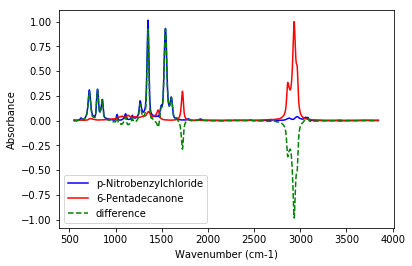

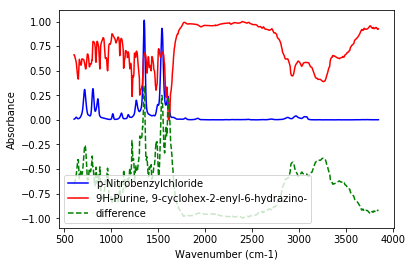

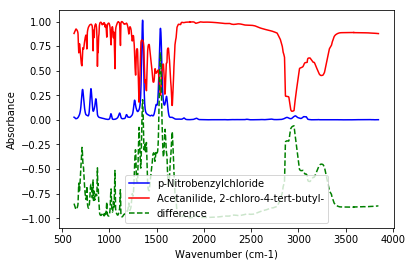

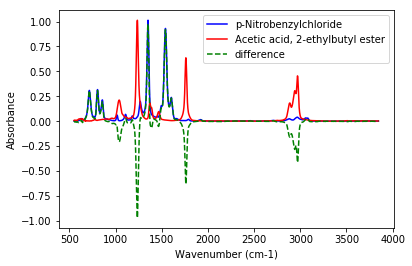

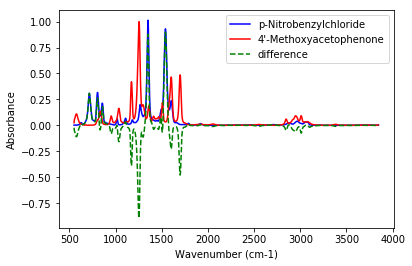

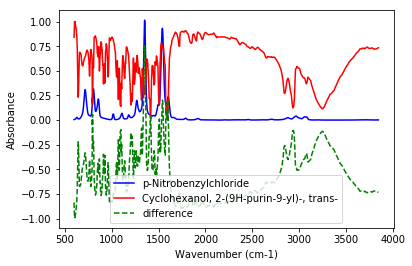

In [35]:
#import os
#import glob
#from common import *
#import pandas as pd


# choose current directory
curr_directory = os.getcwd()
os.chdir(curr_directory)  # set to current directory
files = glob.glob('reference/*')  # look for files without extension. Returns a list.

#perform a simple spectral matching using a Eucledian distance algorithm

euclidean_df=pd.DataFrame(columns=['Name','Euclidean_dist']) #a DataFrame to store calculated Euclidean distance

for file in files:
    try:
        unknown_spectrum=jcamp.JCAMP_reader("unknown") #load unknown spectrum data
        d=calculate_euclidean_dist(unknown_spectrum, jcamp.JCAMP_reader(file))  
        euclidean_df=euclidean_df.append({'Name':jcamp.JCAMP_reader(file)['title'],'Euclidean_dist':d}, ignore_index=True)

    except:
        #print('Error in:', jcamp.JCAMP_reader(file)['title'])
        continue

#NEED to troubleshoot the y-unit conversion. 
#NEED to have a way to filter out reference spectra that have invalid wavelength range.
#It seems normal up above.

In [34]:
#sort answers by Euclidean distance from smallest to highest.
#The one with smallest distance is the most identical.

euclidean_df.sort_values('Euclidean_dist')


,Name,Euclidean_dist
9,p-Nitrobenzylchloride,0.000000
1,"Benzene, 1-ethoxy-4-nitro-",8.120459
14,4'-Methoxyacetophenone,11.311191
3,"1,3,6-Heptatriene",12.207498
13,"Acetic acid, 2-ethylbutyl ester",12.628655
10,6-Pentadecanone,13.104905
6,"2,2-Dimethyltetrahydrofuran",13.380472
7,"2,4-Dimethyl-2,3-pentadiene",14.277681
2,"1,3-Octadiene",14.879104
0,"2,4-Dimethyl-1,3-pentadiene",16.241161


II. Spectral matching using a Convolution Neural Network (CNN)